# Example 6 : TS with Geopsy Profiles

Time series analysis to compute surface response spectrum and site 
amplification functions using velocity profiles from [geopsy](http://www.geopsy.org/).

In [ ]:
import re

import matplotlib.pyplot as plt
import numpy as np

import pystrata

%matplotlib inline

In [ ]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Function to parse the geospy files

In [ ]:
def iter_geopsy_profiles(fname):
    """Read a Geopsy formatted text file created by gpdcreport."""
    with open(fname) as fp:
        next(fp)
        while True:
            try:
                line = next(fp)
            except StopIteration:
                break

            m = re.search(r"Layered model (\d+): value=([0-9.]+)", line)
            id, score = m.groups()
            count = int(next(fp))
            d = {
                "id": id,
                "score": score,
                "layers": [],
            }
            cols = ["thickness", "vel_comp", "vel_shear", "density"]
            for _ in range(count):
                values = [float(p) for p in next(fp).split()]
                d["layers"].append(dict(zip(cols, values)))

            yield d

## Create the input motion

In [ ]:
fname = "data/NIS090.AT2"
ts = pystrata.motion.TimeSeriesMotion.load_at2_file(fname)
ts.accels

array([2.33833e-07, 2.99033e-07, 5.15835e-07, ..., 4.90601e-05,
       4.94028e-05, 4.96963e-05], shape=(4096,))

## Create the site response calculator

In [ ]:
calc = pystrata.propagation.LinearElasticCalculator()

## Specify the output

In [ ]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
    ]
)

## Create site profiles

Iterate over the geopsy profiles and create a site profile. For this example, we just use a linear elastic properties.

In [ ]:
fname = "data/best100_GM_linux.txt"

for geopsy_profile in iter_geopsy_profiles(fname):
    profile = pystrata.site.Profile(
        [
            pystrata.site.Layer(
                pystrata.site.SoilType(
                    "soil-%d" % i,
                    layer["density"] / pystrata.site.GRAVITY,
                    damping=0.05,
                ),
                layer["thickness"],
                layer["vel_shear"],
            )
            for i, layer in enumerate(geopsy_profile["layers"])
        ]
    )
    # Use 1% damping for the half-space
    profile[-1].soil_type.damping = 0.01
    # Compute the waves from the last layer
    calc(ts, profile, profile.location("outcrop", index=-1))
    # Compute the site amplification
    outputs(calc)

## Plot the outputs

Create a few plots of the output.

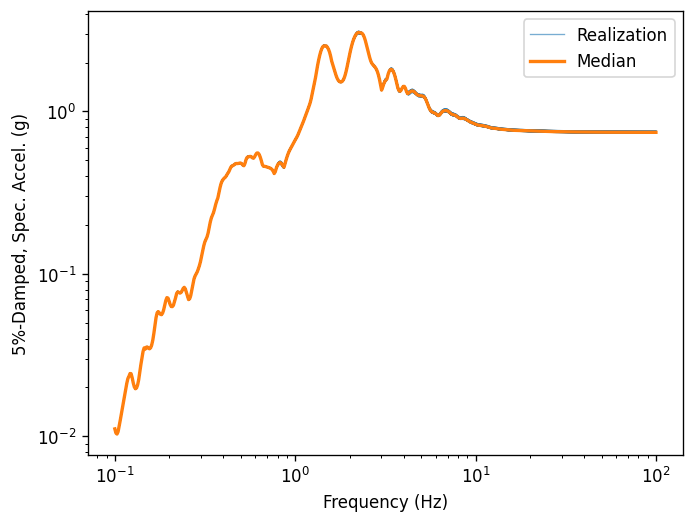

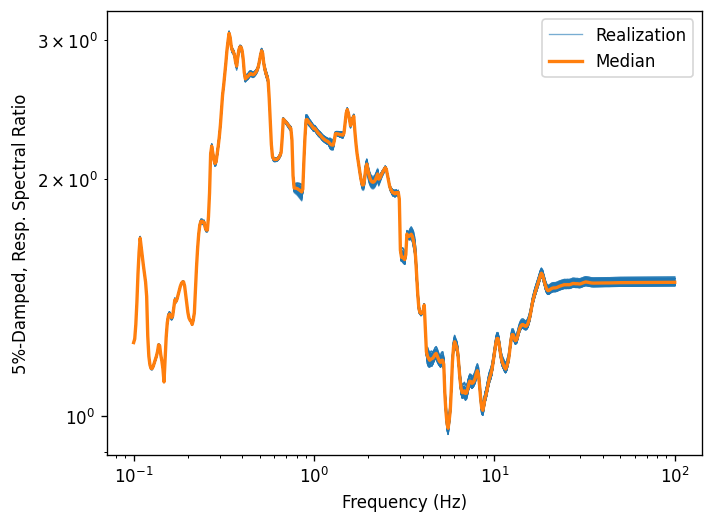

In [ ]:
for o in outputs:
    o.plot(style="stats")